In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text
from tensorflow import keras
import seaborn as sns

# read model metric data, drop duplicated column
df = pd.read_csv('Test_2/evaluation.csv')
df = df.drop(labels ="Unnamed: 0", axis=1)
df.head()

,loss,accuracy,epoch
0,2.136465,0.235854,1
1,1.870161,0.371731,2
2,1.709208,0.443295,3
3,1.604467,0.481336,4
4,1.524378,0.506419,5


In [ ]:
# visualise accuracy after training
plt.plot(df['accuracy'])
plt.plot(df['loss'])

In [2]:
# load the saved model
model =  keras.models.load_model('Test_2/model')

In [3]:
# creat dict to decode predictions
catagory_dict = {'Blockchain':0,
    'Cryptocurrency':1,
    'Genetic engineering':2,
    'Machine learning':3,
    'Nanotechnology':4,
    'Quantum computing':5,
    'Robotics':6,
    'Social engineering':7,
    'Space exploration':8,
    'Virtual reality':9,
}

In [4]:
# read test_data, drop duplicate axis from previous steps
test_data = pd.read_csv('Test_2/clean_data.csv')
test_data.sample(5)

,Text,Code
4351,"notably, many of\nthe open problems considered...",3
2853,"such a criteria may \nbe technological, energe...",1
630,all relevant parties\nand stakeholders should ...,0
6740,"there-\nfore, on the surface, it seems that th...",5
6991,"but, in case of the non-local qubit interactio...",5


In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(test_data['Text'],test_data['Code'])

In [6]:
# use model to predict test dataset, output results to dataframe
predictions = model.predict(x_test)
predictions = pd.DataFrame(predictions)
print(predictions.shape)
predictions.head()

(2804, 10)


,0,1,2,3,4,5,6,7,8,9
0,0.540435,0.578332,0.940394,0.434427,0.835917,0.593349,0.138228,0.260019,0.469679,0.184777
1,0.983019,0.953320,0.247363,0.366592,0.307016,0.684768,0.046473,0.315409,0.238553,0.064776
2,0.908253,0.906294,0.381128,0.279893,0.540392,0.150866,0.235878,0.674599,0.224059,0.412010
3,0.566265,0.311955,0.490683,0.394200,0.324175,0.641271,0.358377,0.182215,0.684999,0.699486
4,0.916401,0.823131,0.518706,0.309839,0.345770,0.903345,0.040858,0.255491,0.716350,0.040420


In [7]:
# find column of max for each row and make new column for 'P' Prediction
results = pd.DataFrame()
results['P'] = predictions.idxmax(axis = 1)
results.head()

,P
0,2
1,0
2,0
3,9
4,0


In [8]:
# append actual encoded values as 'A'
y_test = y_test.reset_index(drop=True)
results['A'] = y_test
results.sample(10)

,P,A
692,4,4
460,1,1
2087,4,4
1118,7,7
1242,6,6
1243,4,7
1923,6,6
2606,1,0
1304,2,2
1586,5,5


In [ ]:
# make new dataframe of just P and A
results = predictions[['P','A']]
results.head()

In [9]:
# calculate a frequency value for each P/A pair
results = results.groupby(results.columns.tolist(),as_index=False).size()
results.head()


,P,A,size
0,0,0,283
1,0,1,78
2,0,2,10
3,0,3,13
4,0,4,17


In [10]:
# convert to numpy array for insertion into matrix
results_array = results.to_numpy()

In [11]:
#generate confusion matrix grid (10 x 10)
mtx = {}
for i in range(10):
    for x in range(10):    
        mtx[i] = {i:np.NaN}
mtx = pd.DataFrame(mtx)
mtx.shape

(10, 10)

In [12]:
# iterate over the np array, use the P/A values as coordinates to insert the respective size value
# any missing values will remain as NaN. once filled, replace NaN with 0 for the heatmap.
# matrix is represented with Predictions on the x axis (columns) and True values on the y axis (rows)
for item in results_array:
    mtx[item[0]][item[1]] = item[2]
mtx = mtx.replace(np.NaN, 0)
mtx

,0,1,2,3,4,5,6,7,8,9
0,283.0,30.0,4.0,2.0,34.0,15.0,4.0,9.0,5.0,2.0
1,78.0,218.0,3.0,2.0,22.0,23.0,0.0,13.0,7.0,4.0
2,10.0,1.0,131.0,0.0,41.0,14.0,1.0,6.0,10.0,0.0
3,13.0,2.0,3.0,16.0,28.0,38.0,0.0,5.0,5.0,25.0
4,17.0,4.0,19.0,1.0,283.0,15.0,0.0,12.0,14.0,1.0
5,16.0,3.0,6.0,2.0,21.0,312.0,2.0,1.0,14.0,2.0
6,13.0,2.0,6.0,2.0,17.0,13.0,113.0,27.0,5.0,24.0
7,8.0,7.0,8.0,0.0,38.0,4.0,1.0,173.0,3.0,11.0
8,10.0,1.0,5.0,6.0,41.0,69.0,2.0,11.0,178.0,0.0
9,10.0,2.0,4.0,2.0,10.0,13.0,10.0,17.0,2.0,84.0


In [14]:
# calculate adjustment values as a ratio of y_test_count/total_count present in the test dataset
counts = test_data.groupby('y_test', as_index=False).size()
counts.rename(columns = {'size':'y_test_count'}, inplace=True)
total_count = len(test_data)
counts["adjustment_factor"] = counts['y_test_count']/total_count
counts

KeyError: 'y_test'

In [ ]:
# transpose matrix to apply adjustment along the True value axis 
# apply the adjustment factor along columns
mtx = mtx.T
mtx = mtx*counts["adjustment_factor"]
mtx

<AxesSubplot:>

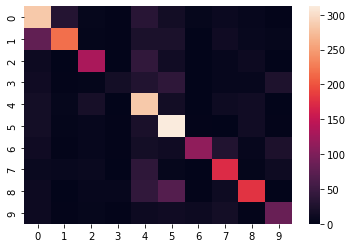

In [13]:
# visualise the confusion matrix using a heatmap
sns.heatmap(mtx)